Epoch 1/100


C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['packet_input', 'temporal_input', 'protocol_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.6482 - packet_output_loss: 0.4924 - protocol_output_loss: 0.7080 - temporal_output_loss: 0.4478 - val_loss: 0.5399 - val_packet_output_loss: 0.0445 - val_protocol_output_loss: 0.4800 - val_temporal_output_loss: 0.0161
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2361 - packet_output_loss: 0.0298 - protocol_output_loss: 0.1934 - temporal_output_loss: 0.0129 - val_loss: 0.1618 - val_packet_output_loss: 0.0244 - val_protocol_output_loss: 0.1281 - val_temporal_output_loss: 0.0106
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0664 - packet_output_loss: 0.0163 - protocol_output_loss: 0.0428 - temporal_output_loss: 0.0074 - val_loss: 0.1291 - val_packet_output_loss: 0.0171 - val_protocol_output_loss: 0.1034 - val_temporal_output_loss: 0.0100
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0293 - packet_output_loss: 0.0087 - protocol_output_loss: 0.0154 - temporal_output_loss: 0.0052 - val_loss

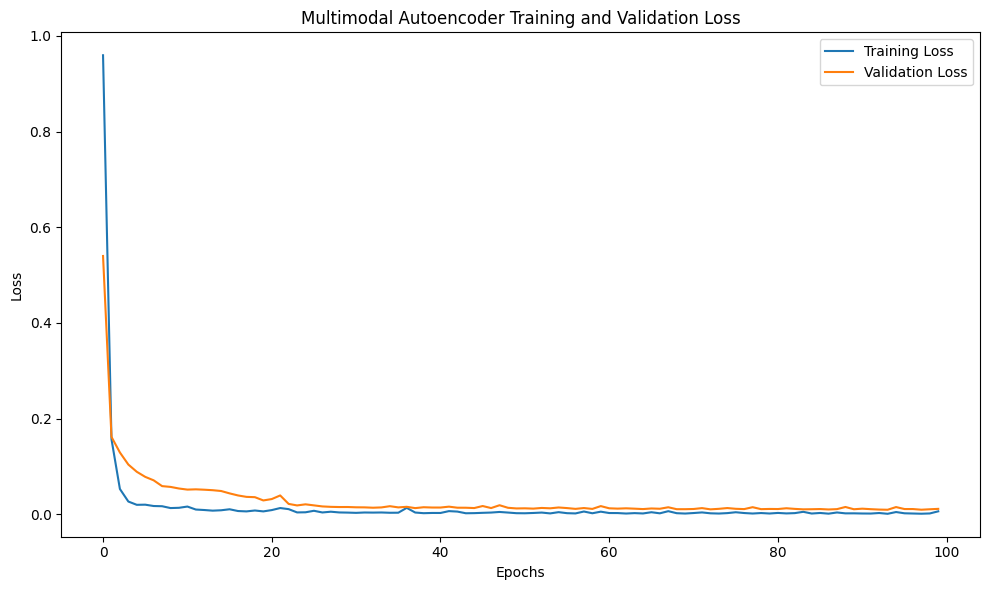

Model training completed. Model and scalers saved.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import MeanSquaredError

# Instantiate the Mean Squared Error loss
mse = MeanSquaredError()
import matplotlib.pyplot as plt

def create_multimodal_autoencoder(packet_input_size, temporal_input_size, protocol_input_size):
    # Define input layers for each modality
    packet_input = Input(shape=(packet_input_size,), name="packet_input")
    temporal_input = Input(shape=(temporal_input_size,), name="temporal_input")
    protocol_input = Input(shape=(protocol_input_size,), name="protocol_input")

    # Packet encoder
    packet_encoded = Dense(64, activation='relu')(packet_input)
    packet_encoded = Dense(32, activation='relu')(packet_encoded)

    # Temporal encoder
    temporal_encoded = Dense(64, activation='relu')(temporal_input)
    temporal_encoded = Dense(32, activation='relu')(temporal_encoded)

    # Protocol encoder
    protocol_encoded = Dense(16, activation='relu')(protocol_input)
    protocol_encoded = Dense(8, activation='relu')(protocol_encoded)

    # Combine the encoded representations
    combined = Concatenate()([packet_encoded, temporal_encoded, protocol_encoded])

    # Shared latent space
    latent = Dense(32, activation='relu', name="latent_space")(combined)

    # Decoders for each modality
    # Packet decoder
    packet_decoded = Dense(32, activation='relu')(latent)
    packet_decoded = Dense(64, activation='relu')(packet_decoded)
    packet_decoded = Dense(packet_input_size, activation='linear', name="packet_output")(packet_decoded)

    # Temporal decoder
    temporal_decoded = Dense(32, activation='relu')(latent)
    temporal_decoded = Dense(64, activation='relu')(temporal_decoded)
    temporal_decoded = Dense(temporal_input_size, activation='linear', name="temporal_output")(temporal_decoded)

    # Protocol decoder
    protocol_decoded = Dense(8, activation='relu')(latent)
    protocol_decoded = Dense(16, activation='relu')(protocol_decoded)
    protocol_decoded = Dense(protocol_input_size, activation='linear', name="protocol_output")(protocol_decoded)

    # Build the autoencoder model
    autoencoder = Model(
        inputs=[packet_input, temporal_input, protocol_input], 
        outputs=[packet_decoded, temporal_decoded, protocol_decoded]
    )

    # Compile the model
    autoencoder.compile(
        optimizer='adam', 
        loss={
            'packet_output': 'mean_squared_error', 
            'temporal_output': 'mean_squared_error', 
            'protocol_output': 'mean_squared_error'
        }
    )

    return autoencoder

def train_multimodal_autoencoder(data_path):
    # Load the dataset
    data = pd.read_csv(data_path)

    # Define feature groups
    packet_features = ['ul_total_num_pkts', 'ul_total_num_bytes', 'ul_min_pkt_size', 
                   'ul_max_pkt_size', 'ul_mean_pkt_size', 'ul_std_pkt_size', 
                   'dl_total_num_pkts', 'dl_total_num_bytes', 'dl_min_pkt_size', 
                   'dl_max_pkt_size', 'dl_mean_pkt_size', 'dl_std_pkt_size']

   
    temporal_features = ['ul_min_iat', 'ul_max_iat', 'ul_mean_iat', 'ul_std_iat', 'ul_dur',
                     'dl_min_iat', 'dl_max_iat', 'dl_mean_iat', 'dl_std_iat', 'dl_dur']

    protocol_features = ['protocal', 'port_A', 'port_B','ip_A', 'ip_B']

    # Separate features
    X_packet = data[packet_features]
    X_temporal = data[temporal_features]
    X_protocol = data[protocol_features]

    # Normalize features
    scaler_packet = StandardScaler()
    scaler_temporal = StandardScaler()
    scaler_protocol = StandardScaler()

    X_packet_scaled = scaler_packet.fit_transform(X_packet)
    X_temporal_scaled = scaler_temporal.fit_transform(X_temporal)
    X_protocol_scaled = scaler_protocol.fit_transform(X_protocol)

    # Create and train the autoencoder
    autoencoder = create_multimodal_autoencoder(
        len(packet_features), 
        len(temporal_features), 
        len(protocol_features)
    )

    # Train the autoencoder
    history = autoencoder.fit(
        [X_packet_scaled, X_temporal_scaled, X_protocol_scaled], 
        [X_packet_scaled, X_temporal_scaled, X_protocol_scaled], 
        epochs=100, 
        batch_size=64, 
        validation_split=0.2,
        verbose=1
    )

    # Save the model and scalers
    autoencoder.save("multimodal_random_smoteenn_autoencoder.h5", save_format='h5')
    import joblib
    joblib.dump(scaler_packet, 'packet_scaler.pkl')
    joblib.dump(scaler_temporal, 'temporal_scaler.pkl')
    joblib.dump(scaler_protocol, 'protocol_scaler.pkl')

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Multimodal Autoencoder Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

    print("Model training completed. Model and scalers saved.")

# Example usage
if __name__ == "__main__":
    train_multimodal_autoencoder('balanced_random_smoteenn.csv')

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['packet_input', 'temporal_input', 'protocol_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

Classification Performance Metrics:
Accuracy: 0.8099
Precision (Weighted): 0.8102
Recall (Weighted): 0.8099
F1 Score (Weighted): 0.8096

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       326
           1       0.77      0.81      0.79       285
           2       0.77      0.80      0.79       350
           3       0.85      0.88      0.86       328
           4       0.83      0.79      0.81       301
           5       0.81      0.82      0.82       328
           6       0.76      0.83      0.80       313
           7       0.88      0.87      0.87       324
           8       0.81      0.76      0.78       317
           9       0.79      0.79      0.79       336
          10       0.72      0.70      0.71       284
          11       0.84      0.81      0.82       344
          12       0.81      0.75      0.78       329
          13       0.83      0.8

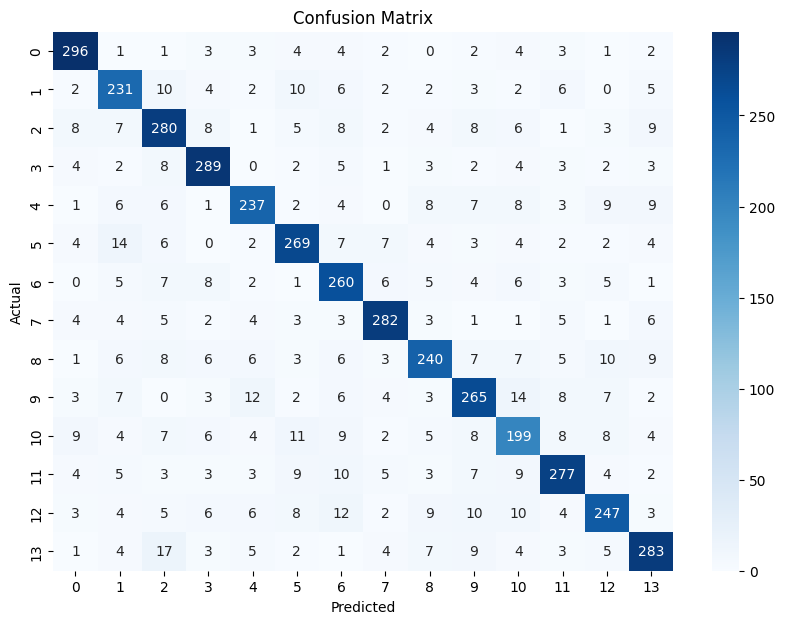

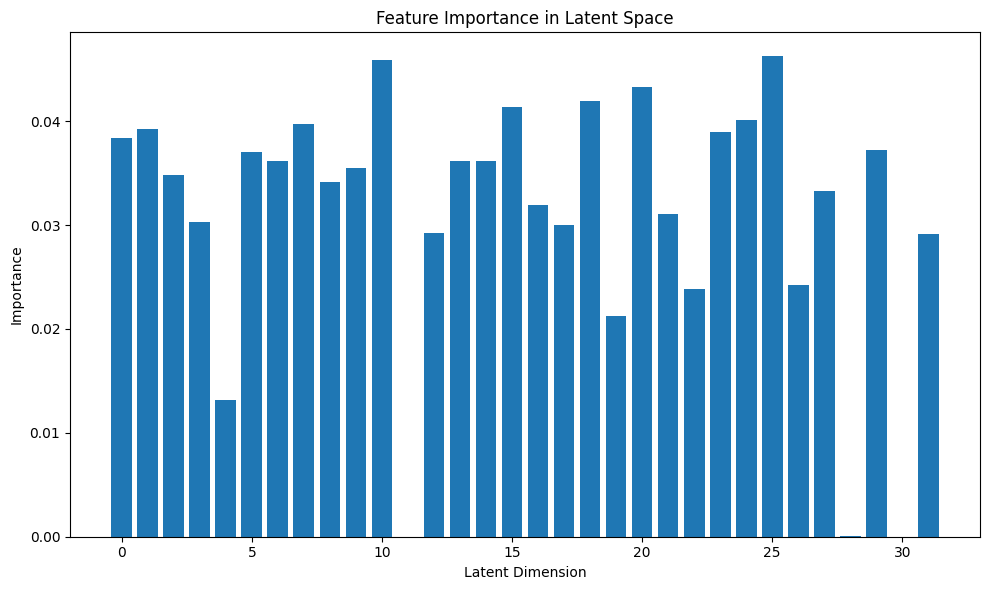

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
import seaborn as sns
from tensorflow.keras.models import Model, load_model

# Scikit-learn imports for classification and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)

def extract_latent_representations(model_path, data_path, feature_groups):
    """
    Extract latent space representations from the trained autoencoder
    
    Parameters:
    - model_path: Path to the saved autoencoder model
    - data_path: Path to the input data CSV
    - feature_groups: Dictionary of feature groups
    
    Returns:
    - Latent space representations
    - Corresponding labels
    """
    # Load the model
    autoencoder = load_model(model_path, custom_objects={'MeanSquaredError': None})
    
    # Load scalers
    scaler_packet = joblib.load('packet_scaler.pkl')
    scaler_temporal = joblib.load('temporal_scaler.pkl')
    scaler_protocol = joblib.load('protocol_scaler.pkl')
    
    # Load data
    data = pd.read_csv(data_path)
    
    # Separate features
    X_packet = scaler_packet.transform(data[feature_groups['packet_features']])
    X_temporal = scaler_temporal.transform(data[feature_groups['temporal_features']])
    X_protocol = scaler_protocol.transform(data[feature_groups['protocol_features']])
    
    # Extract latent space representations
    encoder = Model(
        inputs=autoencoder.inputs, 
        outputs=autoencoder.get_layer('latent_space').output
    )
    latent_representations = encoder.predict([X_packet, X_temporal, X_protocol])
    
    # Extract labels (assuming the last column is the class label)
    y = data.iloc[:, -1]
    
    return latent_representations, y

def train_random_forest_on_latent_space(latent_reps, labels):
    """
    Train Random Forest Classifier on latent space representations
    
    Parameters:
    - latent_reps: Latent space representations
    - labels: Corresponding class labels
    
    Returns:
    - Trained Random Forest Classifier
    - Train and test sets
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        latent_reps, labels, test_size=0.2, random_state=42
    )
    
    # Train Random Forest Classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1
    )
    rf_classifier.fit(X_train, y_train)
    
    return rf_classifier, (X_train, X_test, y_train, y_test)

def evaluate_classification_performance(classifier, X_test, y_test):
    """
    Evaluate the performance of the Random Forest Classifier
    
    Parameters:
    - classifier: Trained Random Forest Classifier
    - X_test: Test features
    - y_test: Test labels
    
    Returns:
    - Dictionary of performance metrics
    """
    # Predict on test set
    y_pred = classifier.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (Weighted)': precision_score(y_test, y_pred, average='weighted'),
        'Recall (Weighted)': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score (Weighted)': f1_score(y_test, y_pred, average='weighted')
    }
    
    # Print metrics
    print("\nClassification Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Print detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
   
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return metrics

def main():
    # Define feature groups (adjust according to your dataset)
    feature_groups = {
         'packet_features' : ['ul_total_num_pkts', 'ul_total_num_bytes', 'ul_min_pkt_size', 
                   'ul_max_pkt_size', 'ul_mean_pkt_size', 'ul_std_pkt_size', 
                   'dl_total_num_pkts', 'dl_total_num_bytes', 'dl_min_pkt_size', 
                   'dl_max_pkt_size', 'dl_mean_pkt_size', 'dl_std_pkt_size'],

   
         'temporal_features' : ['ul_min_iat', 'ul_max_iat', 'ul_mean_iat', 'ul_std_iat', 'ul_dur',
                     'dl_min_iat', 'dl_max_iat', 'dl_mean_iat', 'dl_std_iat', 'dl_dur'],

         'protocol_features' : ['protocal', 'port_A', 'port_B','ip_A', 'ip_B']
    }
    
    # Extract latent representations
    latent_representations, labels = extract_latent_representations(
        'multimodal_random_smoteenn_autoencoder.h5', 
        'balanced_random_smoteenn.csv',  # Your input dataset
        feature_groups
    )
    
    # Train Random Forest on latent space
    rf_classifier, (X_train, X_test, y_train, y_test) = train_random_forest_on_latent_space(
        latent_representations, labels
    )
    
    # Evaluate classification performance
    performance_metrics = evaluate_classification_performance(
        rf_classifier, X_test, y_test
    )
    
    # Optional: Feature importance in the latent space
    plt.figure(figsize=(10, 6))
    feature_importance = rf_classifier.feature_importances_
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.title('Feature Importance in Latent Space')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    plt.close()

if __name__ == "__main__":
    main()

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['packet_input', 'temporal_input', 'protocol_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Performance Metrics:
Accuracy: 0.6945
Precision (Weighted): 0.6797
Recall (Weighted): 0.6945
F1 Score (Weighted): 0.6764

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.64      0.75        14
           1       0.50      0.21      0.30        14
           2       0.55      0.44      0.49        25
           3       0.85      0.81      0.83        48
           4       0.69      0.88      0.77       172
           5       0.53      0.57      0.55        35
           6       0.20      0.10      0.13        21
           7       0.67      0.82      0.74        38
           8       0.83      0.93      0.88       106
           9       0.33      0.09      0.14        11
          10       0.43      0.20      0.27        15
          11       0.69      0.57      0.62        42
          12       0.55      0.55      0.55        11
          13       0.43      0.5

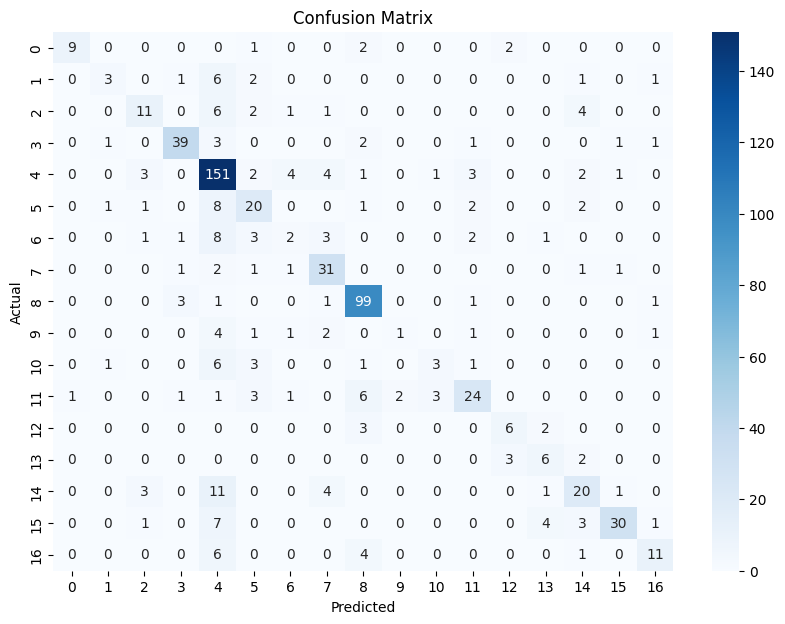

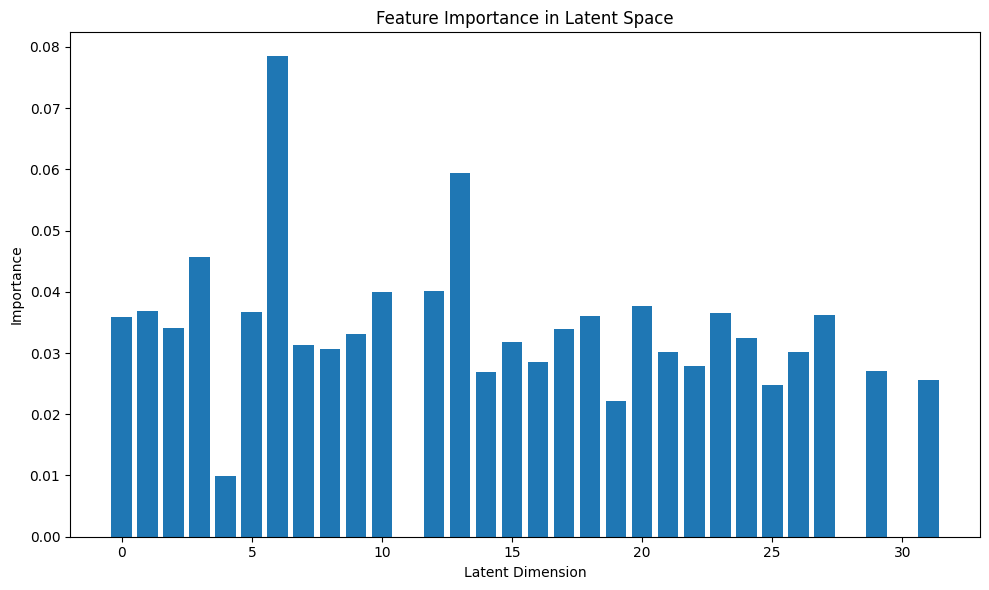

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
import seaborn as sns
from tensorflow.keras.models import Model, load_model

# Scikit-learn imports for classification and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)

def extract_latent_representations(model_path, data_path, feature_groups):
    """
    Extract latent space representations from the trained autoencoder
    
    Parameters:
    - model_path: Path to the saved autoencoder model
    - data_path: Path to the input data CSV
    - feature_groups: Dictionary of feature groups
    
    Returns:
    - Latent space representations
    - Corresponding labels
    """
    # Load the model
    autoencoder = load_model(model_path, custom_objects={'MeanSquaredError': None})
    
    # Load scalers
    scaler_packet = joblib.load('packet_scaler.pkl')
    scaler_temporal = joblib.load('temporal_scaler.pkl')
    scaler_protocol = joblib.load('protocol_scaler.pkl')
    
    # Load data
    data = pd.read_csv(data_path)
    
    # Separate features
    X_packet = scaler_packet.transform(data[feature_groups['packet_features']])
    X_temporal = scaler_temporal.transform(data[feature_groups['temporal_features']])
    X_protocol = scaler_protocol.transform(data[feature_groups['protocol_features']])
    
    # Extract latent space representations
    encoder = Model(
        inputs=autoencoder.inputs, 
        outputs=autoencoder.get_layer('latent_space').output
    )
    latent_representations = encoder.predict([X_packet, X_temporal, X_protocol])
    
    # Extract labels (assuming the last column is the class label)
    y = data.iloc[:, -1]
    
    return latent_representations, y

def train_random_forest_on_latent_space(latent_reps, labels):
    """
    Train Random Forest Classifier on latent space representations
    
    Parameters:
    - latent_reps: Latent space representations
    - labels: Corresponding class labels
    
    Returns:
    - Trained Random Forest Classifier
    - Train and test sets
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        latent_reps, labels, test_size=0.2, random_state=42
    )
    
    # Train Random Forest Classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1
    )
    rf_classifier.fit(X_train, y_train)
    
    return rf_classifier, (X_train, X_test, y_train, y_test)

def evaluate_classification_performance(classifier, X_test, y_test):
    """
    Evaluate the performance of the Random Forest Classifier
    
    Parameters:
    - classifier: Trained Random Forest Classifier
    - X_test: Test features
    - y_test: Test labels
    
    Returns:
    - Dictionary of performance metrics
    """
    # Predict on test set
    y_pred = classifier.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (Weighted)': precision_score(y_test, y_pred, average='weighted'),
        'Recall (Weighted)': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score (Weighted)': f1_score(y_test, y_pred, average='weighted')
    }
    
    # Print metrics
    print("\nClassification Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Print detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
   
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return metrics

def main():
    # Define feature groups (adjust according to your dataset)
    feature_groups = {
         'packet_features' : ['ul_total_num_pkts', 'ul_total_num_bytes', 'ul_min_pkt_size', 
                   'ul_max_pkt_size', 'ul_mean_pkt_size', 'ul_std_pkt_size', 
                   'dl_total_num_pkts', 'dl_total_num_bytes', 'dl_min_pkt_size', 
                   'dl_max_pkt_size', 'dl_mean_pkt_size', 'dl_std_pkt_size'],

   
         'temporal_features' : ['ul_min_iat', 'ul_max_iat', 'ul_mean_iat', 'ul_std_iat', 'ul_dur',
                     'dl_min_iat', 'dl_max_iat', 'dl_mean_iat', 'dl_std_iat', 'dl_dur'],

         'protocol_features' : ['protocal', 'port_A', 'port_B','ip_A', 'ip_B']
    }
    
    # Extract latent representations
    latent_representations, labels = extract_latent_representations(
        'multimodal_random_smoteenn_autoencoder.h5', 
        'Processed_wild.csv',  # Your input dataset
        feature_groups
    )
    
    # Train Random Forest on latent space
    rf_classifier, (X_train, X_test, y_train, y_test) = train_random_forest_on_latent_space(
        latent_representations, labels
    )
    
    # Evaluate classification performance
    performance_metrics = evaluate_classification_performance(
        rf_classifier, X_test, y_test
    )
    
    # Optional: Feature importance in the latent space
    plt.figure(figsize=(10, 6))
    feature_importance = rf_classifier.feature_importances_
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.title('Feature Importance in Latent Space')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    plt.close()

if __name__ == "__main__":
    main()